In [1]:
import os
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from PIL import Image
import keras
import cv2
np.random.seed(42)
%matplotlib inline

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7999009589363110827
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14740844295847932876
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16170236397680937798
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15519156031375211326
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11632882484
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 16264750624290028722
physical_device_desc: "device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:03:00.0, compute capability: 5.2"
, name: "/device:GPU:1"
device_type: "

In [3]:
from IPython.display import Video
Video("data/train.mp4")

In [4]:
from IPython.display import Video
Video("data/test.mp4")

In [5]:
! wc -l data/train.txt

20399 data/train.txt


In [6]:
# %%time
# os.makedirs('data/train', exist_ok=True)
# vidcap = cv2.VideoCapture('data/train.mp4')
# success, image = vidcap.read()
# count = 0
# while success:
#     cv2.imwrite("data/train/frame%d.jpg" %count, image)     # save frame as JPEG file      
#     success,image = vidcap.read()
#     count += 1

In [7]:
# %%time
# os.makedirs('data/test', exist_ok=True)
# vidcap = cv2.VideoCapture('data/test.mp4')
# success, image = vidcap.read()
# count = 0
# while success:
#     cv2.imwrite("data/test/frame%d.jpg" %count, image)     # save frame as JPEG file      
#     success,image = vidcap.read()
#     count += 1

In [8]:
!ls -lR data/train/*.jpg | wc -l
!ls -lR data/test/*.jpg | wc -l

20400
10798


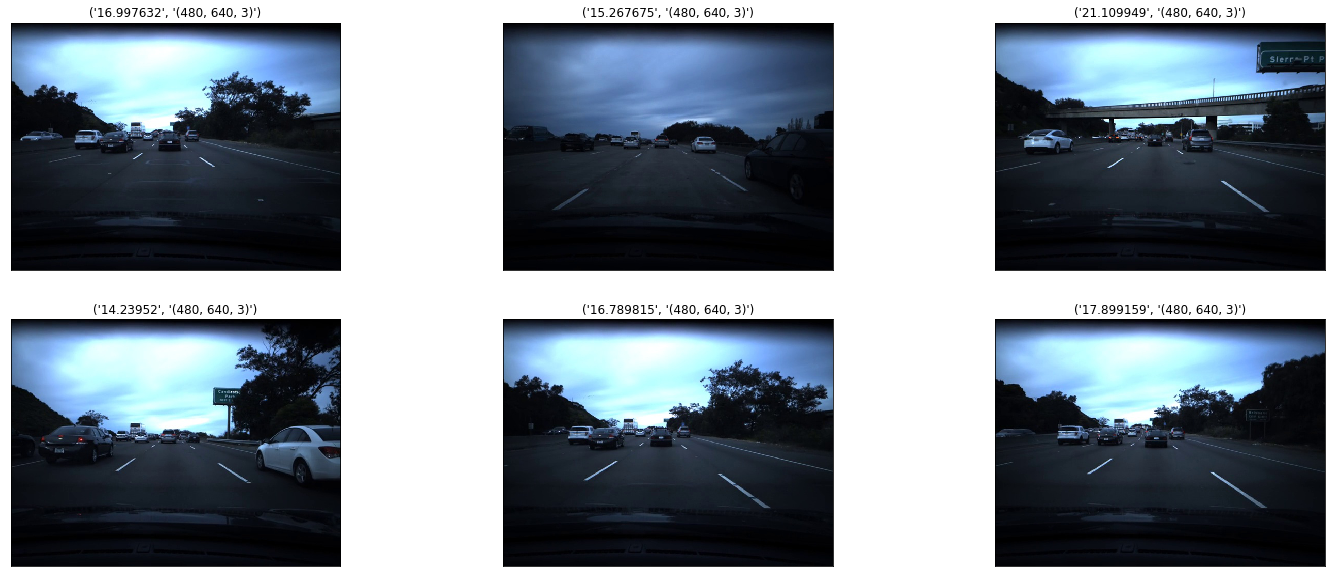

In [9]:
# plot the images in the batch, along with the corresponding labels
lbls = np.loadtxt('data/train.txt')
fig = plt.figure(figsize=(25, 10))

for idx in np.arange(6):
    ax = fig.add_subplot(2, 6/2, idx+1, xticks=[], yticks=[])
    rnd_index = np.random.randint(0, 2000)
    img = plt.imread("data/train/frame"+str(idx+rnd_index)+".jpg")
    ax.imshow(img)
    # print out the correct label for each image
    ax.set_title((str(lbls[idx+rnd_index]), str(img.shape)))

### Different Models


We will experiement with different architectures and refer to paper below.

http://cs231n.stanford.edu/reports/2017/pdfs/626.pdf


In [ ]:
# !pip install git+https://github.com/qubvel/efficientnet
# !pip install keras-vis

### Transfer Learning

Using [Efficient Nets](https://arxiv.org/pdf/1905.11946.pdf) and [github repo](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet)

In [11]:
bs = 128 * 2
img_size = 256
img_shape = (256, 256, 3) 

In [30]:
from efficientnet.keras import EfficientNetB3
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D, Add
from keras.layers import Dropout, Conv3D, BatchNormalization, GRU, Input, MaxPooling3D, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet_v2 import ResNet50V2, ResNet101V2 
from keras import optimizers, applications
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.utils.multi_gpu_utils import multi_gpu_model

In [13]:
x = ['frame'+str(i)+'.jpg' for i in range(20400)]
y = np.loadtxt('data/train.txt').tolist()

In [14]:
df = pd.DataFrame(list(zip(x, y)), columns=['filename', 'speed'])
df.head()

,filename,speed
0,frame0.jpg,28.105569
1,frame1.jpg,28.105569
2,frame2.jpg,28.106527
3,frame3.jpg,28.130404
4,frame4.jpg,28.109243


In [15]:
df_shuff = shuffle(df)
df_train = df_shuff.iloc[:int(len(df)*0.8)]
df_val = df_shuff.iloc[int(len(df)*0.8):]
print ('Training data:', df_train.shape)
print ('Validation data:', df_val.shape)

Training data: (16320, 2)
Validation data: (4080, 2)


In [16]:
def sky_crop(img):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    return img[75:, :, :]

def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

In [17]:
# initialize more data augmentation tricks
train_datagen = ImageDataGenerator(
                rescale=1./255,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
train_generator = train_datagen.flow_from_dataframe(df_train, directory='data/train', 
                                                    x_col='filename', y_col='speed', 
                                                    target_size=(img_size, img_size), color_mode='rgb', 
                                                    class_mode='raw', batch_size=bs, shuffle=True, seed=42)
# train_generator = crop_generator(train_generator)

Found 16320 validated image filenames.


In [19]:
val_generator = test_datagen.flow_from_dataframe(df_val, directory='data/train',
                                                 x_col='filename', y_col='speed',
                                                 target_size=(img_size, img_size), color_mode='rgb',
                                                 class_mode='raw', batch_size=bs, shuffle=False, seed=42)

Found 4080 validated image filenames.


### Resnet 50

In [37]:
base_model = keras.applications.resnet_v2.ResNet50V2(weights='imagenet', include_top=False, input_shape=img_shape)

In [38]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)

predictions = Dense(1)(x)

In [39]:
# train only the top layers
for layer in base_model.layers:
    layer.trainable = False

In [23]:
# # we'll store a copy of the model on *every* GPU and then combine
# # the results from the gradient updates on the CPU
# with tf.device("/cpu:0"):
#     # initialize the model
#     model = Model(inputs=base_model.input, outputs=predictions)

# # make the model parallel
# model = multi_gpu_model(model, gpus=2)

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 130, 130, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [24]:
# compile the model
opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True)
model.compile(optimizer=opt, loss='mse')

In [25]:
filepath = "data/models/resnet50v2_nofinetune_weights_" + "-{epoch:02d}-{val_loss:.5f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', verbose=1, patience=5)
lr_reduce = ReduceLROnPlateau(monitor='val_loss',
                              patience=2,
                              verbose=1,
                              factor=0.5,
                              min_lr=0.0000001)

In [ ]:
model.fit_generator(
        train_generator,
        steps_per_epoch=200,
        epochs=50,
        validation_data=val_generator,
        validation_steps=100,
        callbacks = [checkpoint, es, lr_reduce])

In [ ]:
# Let's take a look to see how many layers are in the base model = 190
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 10

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[-fine_tune_at:]:
    layer.trainable =  True

In [ ]:
model.summary()

In [ ]:
# compile the model
opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=True)
model.compile(optimizer=opt, loss='mse')

In [ ]:
filepath = "data/models/resnet50v2_finetune_weights_" + "-{epoch:02d}-{val_loss:.5f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', verbose=1, patience=5)
lr_reduce = ReduceLROnPlateau(monitor='val_loss',
                              patience=2,
                              verbose=1,
                              factor=0.5,
                              min_lr=0.0000001)

In [ ]:
model.fit_generator(
        train_generator,
        steps_per_epoch=200,
        epochs=50,
        validation_data=val_generator,
        validation_steps=100,
        callbacks = [checkpoint, es, lr_reduce])


In [ ]:
path = 'data/models/resnet50v2_finetune_weights'
model = load_model(path)
model.summary()

In [ ]:
img1 = plt.imread("data/test/frame"+str(0)+".jpg")
img2 = plt.imread("data/test/frame"+str(1)+".jpg")

In [ ]:
from vis.utils import utils
from keras import activations

# Hide warnings on Jupyter Notebook
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.cm as cm
from vis.visualization import visualize_cam

penultimate_layer = utils.find_layer_idx(model, 'conv5_block3_3_conv')

for modifier in [None, 'guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle("vanilla" if modifier is None else modifier)
    for i, img in enumerate([img1, img2]):    
        # 20 is the imagenet index corresponding to `ouzel`
        grads = visualize_cam(model, layer_idx, filter_indices=20, 
                              seed_input=img, penultimate_layer_idx=penultimate_layer,
                              backprop_modifier=modifier)        
        # Lets overlay the heatmap onto original image.    
        jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
        ax[i].imshow(overlay(jet_heatmap, img))

### EfficientNet B3

In [33]:
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=img_shape)

In [34]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)

predictions = Dense(1)(x)

In [35]:
# train only the top layers
for layer in base_model.layers:
    layer.trainable = False

In [23]:
# # we'll store a copy of the model on *every* GPU and then combine
# # the results from the gradient updates on the CPU
# with tf.device("/cpu:0"):
#     # initialize the model
#     model = Model(inputs=base_model.input, outputs=predictions)

# # make the model parallel
# model = multi_gpu_model(model, gpus=2)

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            11718313    lambda_1[0][0]                   
                                                                 lambda_2[0][0]             

In [24]:
# compile the model
opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True)
model.compile(optimizer=opt, loss='mse')

In [25]:
filepath = "data/models/nofinetune_weights_" + "-{epoch:02d}-{val_loss:.5f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', verbose=1, patience=5)
lr_reduce = ReduceLROnPlateau(monitor='val_loss',
                              patience=2,
                              verbose=1,
                              factor=0.5,
                              min_lr=0.0000001)

In [26]:
model.fit_generator(
        train_generator,
        steps_per_epoch=200,
        epochs=50,
        validation_data=val_generator,
        validation_steps=100,
        callbacks = [checkpoint, es, lr_reduce])

Epoch 1/50
200/200 [==============================] - 891s 4s/step - loss: 21.5100 - val_loss: 53.3794

Epoch 00001: val_loss improved from inf to 53.37943, saving model to data/models/finetune_weights_-01-53.37943.hdf5
Epoch 2/50
200/200 [==============================] - 856s 4s/step - loss: 6.3948 - val_loss: 78.9658

Epoch 00002: val_loss did not improve from 53.37943
Epoch 3/50
200/200 [==============================] - 838s 4s/step - loss: 4.8231 - val_loss: 50.4064

Epoch 00003: val_loss improved from 53.37943 to 50.40636, saving model to data/models/finetune_weights_-03-50.40636.hdf5
Epoch 4/50
200/200 [==============================] - 836s 4s/step - loss: 3.7885 - val_loss: 51.0067

Epoch 00004: val_loss did not improve from 50.40636
Epoch 5/50
200/200 [==============================] - 837s 4s/step - loss: 3.1177 - val_loss: 91.9737

Epoch 00005: val_loss did not improve from 50.40636

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/50

In [27]:
# Let's take a look to see how many layers are in the base model = 659 (B6) 467 (B4)
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[-fine_tune_at:]:
    layer.trainable =  True

Number of layers in the base model:  377


In [28]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            11718313    lambda_1[0][0]                   
                                                                 lambda_2[0][0]             

/home/visionosl/.virtualenvs/dl/lib/python3.5/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [29]:
# compile the model
opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=True)
model.compile(optimizer=opt, loss='mse')

In [30]:
filepath = "data/models/finetune_weights_" + "-{epoch:02d}-{val_loss:.5f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', verbose=1, patience=5)
lr_reduce = ReduceLROnPlateau(monitor='val_loss',
                              patience=2,
                              verbose=1,
                              factor=0.5,
                              min_lr=0.0000001)

In [32]:
model.fit_generator(
        train_generator,
        steps_per_epoch=200,
        epochs=50,
        validation_data=val_generator,
        validation_steps=100,
        callbacks = [checkpoint, es, lr_reduce])

Epoch 1/50
200/200 [==============================] - 881s 4s/step - loss: 1.0790 - val_loss: 54.7238

Epoch 00001: val_loss improved from inf to 54.72380, saving model to data/models/finetune_weights_-01-54.72380.hdf5
Epoch 2/50
200/200 [==============================] - 837s 4s/step - loss: 0.7008 - val_loss: 37.9465

Epoch 00002: val_loss improved from 54.72380 to 37.94649, saving model to data/models/finetune_weights_-02-37.94649.hdf5
Epoch 3/50
200/200 [==============================] - 838s 4s/step - loss: 0.5579 - val_loss: 27.9257

Epoch 00003: val_loss improved from 37.94649 to 27.92571, saving model to data/models/finetune_weights_-03-27.92571.hdf5
Epoch 4/50
200/200 [==============================] - 838s 4s/step - loss: 0.4304 - val_loss: 35.9130

Epoch 00004: val_loss did not improve from 27.92571
Epoch 5/50
200/200 [==============================] - 839s 4s/step - loss: 0.3765 - val_loss: 29.2464

Epoch 00005: val_loss did not improve from 27.92571

Epoch 00005: ReduceLRO

In [ ]:
path = 'data/models/finetune_weights_-11-21.15099.hdf5'
model = load_model(path)
model.summary()

In [ ]:
img1 = plt.imread("data/test/frame"+str(0)+".jpg")
img2 = plt.imread("data/test/frame"+str(1)+".jpg")

In [ ]:
from vis.utils import utils
from keras import activations

# Hide warnings on Jupyter Notebook
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.cm as cm
from vis.visualization import visualize_cam

penultimate_layer = utils.find_layer_idx(model, 'top_conv')

for modifier in [None, 'guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle("vanilla" if modifier is None else modifier)
    for i, img in enumerate([img1, img2]):    
        # 20 is the imagenet index corresponding to `ouzel`
        grads = visualize_cam(model, layer_idx, filter_indices=20, 
                              seed_input=img, penultimate_layer_idx=penultimate_layer,
                              backprop_modifier=modifier)        
        # Lets overlay the heatmap onto original image.    
        jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
        ax[i].imshow(overlay(jet_heatmap, img))

### 3D Conv LSTM



In [15]:
input_shape = (30, 149, 224, 3)
batch_size = 16

In [16]:
def res_block(x):
    x_prev = x
    x = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x_shortcut = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(x_prev)
    x =  Add()([x, x_shortcut])
    return x

In [17]:
def cnn3d_lstm():
    inputs = Input(shape=input_shape)
    x = Conv3D(filters=3, kernel_size=(3, 3, 3), activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = res_block(x)
    x = res_block(x)
    x = Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = Reshape(target_shape = (3100, 8))(x)
    x = GRU(128, return_sequences=True)(x)
    x = GRU(64, return_sequences=True)(x)
    x = GRU(16)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    outputs = Dense(1)(x)
    
    model = Model(inputs, outputs)
    return model

In [18]:
model = cnn3d_lstm()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 149, 224, 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 28, 147, 222, 246         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 28, 147, 222, 12          conv3d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling3d_1 (MaxPooling3D)  (None, 14, 73, 111,  0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [19]:
# compile the model
opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=True)
model.compile(optimizer=opt, loss='mse')

In [20]:
df_train = df.iloc[:int(len(df)*0.8)]
df_val = df.iloc[int(len(df)*0.8):]
print ('Training data:', df_train.shape)
print ('Validation data:', df_val.shape)

Training data: (16320, 2)
Validation data: (4080, 2)


In [21]:
def sky_crop(img):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    return img[75:, :, :]

def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)
# train_crops = crop_generator(train_generator, 224) #increase target_size in image generator

In [22]:
# read 30 frames apply data augmentation and sky crop

data_path = 'data/train/'

def get_data(df_train):
    x = []
    y = []
    for p in range(0, len(df_train)-31, 31):
        i = p + 1
        img = []
        while (i%31 != 0):
            image_file = df_train['filename'].iloc[i-1]
            img.append(sky_crop(np.asarray(Image.open(data_path+image_file).resize((224, 224)))))
            i += 1
        x.append(np.array(img))
        y.append(df_train['speed'].iloc[i-1].reshape(1,))
    return np.array(x), np.array(y)

In [23]:
train_x, train_y = get_data(df_train)
print (train_x.shape, train_y.shape)
val_x, val_y = get_data(df_val)
print (val_x.shape, val_y.shape)

(526, 30, 149, 224, 3) (526, 1)
(131, 30, 149, 224, 3) (131, 1)


In [24]:
# read 30 frames apply data augmentation and sky crop
def train_generator():
    j = 0
    while 1:
        x = train_x[j*batch_size:j*batch_size+batch_size, :, :, :, :]
        y = train_y[j*batch_size:j*batch_size+batch_size, :]
        j += 1
        yield np.array(x), np.array(y)

In [25]:
# read 30 frames apply data augmentation and sky crop
def val_generator():
    j = 0
    while 1:
        x = val_x[j*batch_size:j*batch_size+batch_size, :, :, :, :]
        y = val_y[j*batch_size:j*batch_size+batch_size, :]
        j += 1
        yield np.array(x), np.array(y)

In [26]:
train_gen = train_generator()
val_gen = val_generator()

In [27]:
filepath = "data/models/3dcnn_" + "-{epoch:02d}-{val_loss:.5f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', verbose=1, patience=5)
lr_reduce = ReduceLROnPlateau(monitor='val_loss',
                              patience=2,
                              verbose=1,
                              factor=0.5,
                              min_lr=0.0000001)

In [ ]:
model.fit_generator(
        train_gen,
        steps_per_epoch=200,
        epochs=50,
        validation_data=val_gen,
        validation_steps=100,
        callbacks = [checkpoint, es, lr_reduce])

Epoch 1/50
 33/200 [===>..........................] - ETA: 34:12 - loss: 244.3427